<a href="https://colab.research.google.com/github/SurajK7/ChestAI/blob/master/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from fastai.vision import *
from torchvision.models import *
from utils import *
import pandas as pd
from pathlib import Path

In [0]:
cp /content/drive/My\ Drive/CheXpert-v1.0-small.zip .

In [0]:
from google.colab import drive
drive.flush_and_unmount()

In [0]:
!unzip -qq CheXpert-v1.0-small.zip
!rm CheXpert-v1.0-small.zip

In [0]:
full_train_df = pd.read_csv('./CheXpert-v1.0-small/train.csv')
full_train_df = add_columns(full_train_df, False)

In [0]:
full_valid_df = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
full_valid_df = add_columns(full_valid_df, True)

In [0]:
# function to create class labels
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [0]:
full_df = pd.concat([full_train_df, full_valid_df])
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [0]:
tfms = get_transforms(do_flip=False, max_zoom=1.0, max_lighting=0.1)

In [0]:
src = ImageList.from_df(full_df, '.', 'Path').split_from_df('train_valid').label_from_df('feature_string',label_delim=';')

In [0]:
data = src.transform(tfms, size=320, padding_mode='zeros', resize_method=ResizeMethod.PAD).databunch(bs=59).normalize(imagenet_stats)

In [0]:
# data = src.transform(tfms, size=320, padding_mode='zeros', resize_method=ResizeMethod.PAD).databunch(bs=56).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.densenet121, pretrained=True, metrics=avg_auc_metric, ps=0.0)

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 8.32E-03


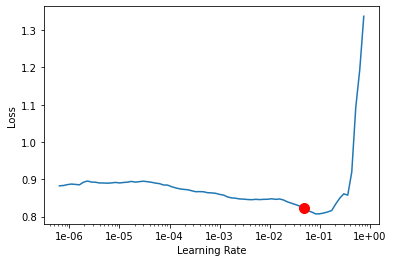

In [12]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr = 4e-2

In [0]:
learn.fit_one_cycle(8, slice(lr), wd=0.1, callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='avg_auc_metric', name='regularization_mixed')])

epoch,train_loss,valid_loss,avg_auc_metric,time


In [0]:
learn.load('bestmodel')

In [0]:
validation_eval(learn, full_valid_df)

234 234
Atelectasis     	 auc: 0.829	 chexpert auc: 0.858	 difference:    0.0292
Cardiomegaly    	 auc: 0.825	 chexpert auc: 0.854	 difference:    0.0287
Consolidation   	 auc: 0.937	 chexpert auc: 0.939	 difference:    0.00243
Edema           	 auc: 0.928	 chexpert auc: 0.941	 difference:    0.0133
Pleural Effusion	 auc: 0.937	 chexpert auc: 0.936	 difference:    -0.000581

Average auc: 0.891 	 CheXpert average auc 0.906	 Difference 0.0146


In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 5.25E-06


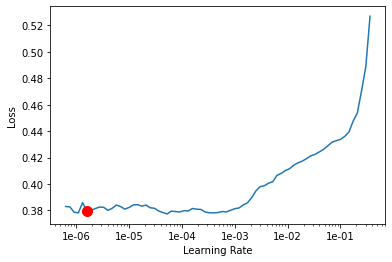

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(6, slice(3e-6, lr/10), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='avg_auc_metric', name='unfreeze_mixed')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.384663,0.427617,0.884805,56:23


Better model found at epoch 0 with avg_auc_metric value: 0.8848053977315632.
